# PHOEBE Backend Under-the-Hood

The backend of PHOEBE intensely uses an internal Python library **libphoebe** written in C/C++. Its purpose is to speed-up complex numerical calculations and could be considered as high-performance computational core of PHOEBE. 

It provides to PHOEBE following functions:
  * triangular meshing via marching algorithm for Roche lobes (detached, misaligned and contact) and Rotating star
  * eclipsing of triangulized bodies
  * horizon determinations
  * reflection/irradiation calculations
  * interface to Wilson-Devinney atmosphere tables
  * some utils functions: interrpolation, limb-darkening function, extinction functions, ...

## Why C/C++ library?

Why would one want use C/C++ library and not purely Python library? Because of the speed of execution (not development) of course. 

For demonstation purpose lets do a short comparision of C/C++ and python execution speeds. For this, we use a program that brute-force searches for the number of primes in a certain range of integers:

In [ ]:
def isPrime(n):
  for i in range(2, n//2+1):
    if (not (n%i)):
      return 0
  return 1

In [2]:
%%time
numPrimes = 0
for i in range(2, 250001):
  numPrimes += isPrime(i)

print(str(numPrimes))

22044
CPU times: user 1min 3s, sys: 3.86 ms, total: 1min 3s
Wall time: 1min 3s


We have a C/C++ counterpart of that Python rutine:

In [3]:
cpp_code = r'''
#include <iostream>

int isPrime(int n) {
  for (int i = 2, m = n/2;  i <= m; ++i) if (! (n % i) ) return 0;
  return 1;
}

int main(){
  int numPrimes = 0;

  for (int i = 2; i < 250001; ++i)
    numPrimes += isPrime(i);

  std::cout << numPrimes << '\n';

  return 0;
}
'''
cpp_filename = "a.cpp"
with open(cpp_filename, 'w') as fout:
    fout.write(cpp_code)

In [4]:
!cat a.cpp                       # printing the code
!g++ a.cpp -o a.e -O3 -Wall      # this compiles the code


#include <iostream>

int isPrime(int n) {
  for (int i = 2, m = n/2;  i <= m; ++i) if (! (n % i) ) return 0;
  return 1;
}

int main(){
  int numPrimes = 0;

  for (int i = 2; i < 250001; ++i)
    numPrimes += isPrime(i);

  std::cout << numPrimes << '\n';

  return 0;
}


Let's run it and time it:

In [5]:
%%time
# run the cpp program
!./a.e

22044
CPU times: user 28.2 ms, sys: 16 ms, total: 44.2 ms
Wall time: 3.06 s


Typically raw C/C++ code is 10-100x faster than raw Python. The execution times of **Python + Numba** code can close to C/C++ performance! But not everything can be ported to Numba.

## Using libphoebe directly

With installation of PHOEBE package also library **libphoebe** is installed. It is easily accessible:

In [6]:
import libphoebe

In [7]:
dir(libphoebe)

['CCM89_extinction',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'gordon_extinction',
 'interp',
 'ld_D',
 'ld_D0',
 'ld_check',
 'ld_gradparD',
 'ld_nrpar',
 'mesh_export_povray',
 'mesh_offseting',
 'mesh_properties',
 'mesh_radiosity_problem',
 'mesh_radiosity_problem_nbody_convex',
 'mesh_radiosity_redistrib_problem_nbody_convex',
 'mesh_radiosity_redistrib_problem_nbody_convex_setup',
 'mesh_rough_visibility',
 'mesh_visibility',
 'planck_function',
 'radiosity_redistrib_1dmodel',
 'roche_Omega',
 'roche_Omega_at_vol',
 'roche_Omega_min',
 'roche_area_volume',
 'roche_central_points',
 'roche_contact_Omega_at_partial_vol',
 'roche_contact_neck_min',
 'roche_contact_partial_area_volume',
 'roche_critical_potential',
 'roche_gradOmega',
 'roche_gradOmega_only',
 'roche_horizon',
 'roche_marching_mesh',
 'roche_misaligned_Omega',
 'roche_misaligned_Omega_at_vol',
 'roche_misaligned_Omega_min',
 'roche_misaligned_area_volume',
 'roche_misaligned_

For this demonstartion let us directly call function 

     roche_misaligned_marching_mesh

from libphoebe and check the results.

In [8]:
help(libphoebe.roche_misaligned_marching_mesh)

Help on built-in function roche_misaligned_marching_mesh in module libphoebe:

roche_misaligned_marching_mesh(...)
    Determine the triangular meshing of generalized Roche lobes with misaligned spin and orbital angular velocity vectors for given values of q, F, d, misalignment(theta or direction) and valueof the generalized Kopal potential Omega0. The edge of triangles used in the mesh are approximately delta.



This routines is used in the backend of PHOEBE to generate meshes of Roche lobes:

In [9]:
# to see where routine is used:
!grep -n -R "roche_misaligned_marching_mesh" --include="*.py" ~/PHOEBE2-GIT/phoebe/

/home/horvat/PHOEBE2-GIT/phoebe/backend/universe.py:2107:            logger.debug("libphoebe.roche_misaligned_marching_mesh{}".format(mesh_args))
/home/horvat/PHOEBE2-GIT/phoebe/backend/universe.py:2109:                new_mesh = libphoebe.roche_misaligned_marching_mesh(*mesh_args,


For detailed description see libphoebe.cpp, line 5558:

    Marching meshing of generalized Roche lobes with misaligned spin and orbit angular
    velocity vector that is implicitely

      Omega(x,y,z) = Omega0

    defined by Avni's generalized Kopal potential:

      Omega(x,y,z,params) =
      1/r1 + q(1/r2 - x/delta^2) +
      1/2 (1 + q) F^2 [(x cos theta' - z sin theta')^2 + y^2]

    r1 = sqrt(x^2 + y^2 + z^2)
    r2 = sqrt((x-delta)^2 + y^2 + z^2)

  Python:

    dict = roche_misaligned_marching_mesh(q, F, d, misalignment, Omega0, delta, <keyword>=[true,false], ... )

  where parameters

    positional:

      q: float = M2/M1 - mass ratio
      F: float - synchronicity parameter
      d: float - separation between the two objects
      misalignment:  in rotated coordinate system:
          float - angle between spin and orbital angular velocity vectors [rad]
      or in canonical coordinate system:
          1-rank numpy array of length 3 = [sx, sy, sz]  |s| = 1
      Omega0: float - value of the generalized Kopal potential
      delta: float - size of triangles edges projected to tangent space

    keywords:
      choice: integer, default 0
          0 - primary lobe
          1 - secondary lobe
        for contacts choice is 0 or 1
        choice controls where is the begining the triangulation

      max_triangles:integer, default 10^7
        maximal number of triangles
        if number of triangles exceeds max_triangles it returns NULL

      full: boolean, default False
        using full version of marching method as given in the paper
        by (Hartmann, 1998)

      vertices: boolean, default False
      vnormals: boolean, default False
      vnormgrads:boolean, default False
      triangles: boolean, default False
      tnormals: boolean, default False
      areas: boolean, default False
      area: boolean, default False
      volume: boolean, default False
      centers: boolean, default False
      cnormals: boolean, default False
      cnormgrads: boolean, default False
      init_phi: float, default 0

  Returns:

    dictionary

  with keywords

    vertices:
      V[][3]    - 2-rank numpy array of vertices

    vnormals:
      NatV[][3] - 2-rank numpy array of normals at vertices

    vnormgrads:
      GatV[]  - 1-rank numpy array of norms of the gradients at central points

    triangles:
      T[][3]    - 2-rank numpy array of 3 indices of vertices
                composing triangles of the mesh aka connectivity matrix

    tnormals:
      NatT[][3] - 2-rank numpy array of normals of triangles

    areas:
      A[]       - 1-rank numpy array of areas of triangles

    area:
      area      - area of triangles of mesh

    volume:
      volume    - volume of body enclosed by triangular mesh

    centers:
      C[][3]    - 2-rank numpy array of central points of triangles
                  central points is  barycentric points projected to
                  Roche lobes
    cnormals:
      NatC[][3]   - 2-rank numpy array of normals of central points

    cnormgrads:
      GatC[]      - 1-rank numpy array of norms of the gradients at central points


  Typically face-vertex format is (V, T) where

    V - vertices
    T - connectivity matrix with indices labeling vertices in
        counter-clockwise orientation so that normal vector is pointing
        outward 

### Detached star

In [10]:
import numpy as np

In [11]:
%%time

q = 1  
F = 1
d = 1
Omega0 = 3.6
delta = 0.01
choice = 0
max_triangles = 10000000 # 10^7

g = 0.3*3.14159
misalignment = np.array([np.sin(g), 0, np.cos(g)])
f = 1.5
R = np.matrix([[1, 0, 0], [0, np.sin(f), -np.cos(f)], [0, np.cos(f), np.sin(f)]])
misalignment = np.dot(R, misalignment)

res = libphoebe.roche_misaligned_marching_mesh(q, F, d, misalignment, Omega0, delta, choice, max_triangles, 
                                               vertices=True, triangles=True, 
                                               cnormgrads=True, area=True, volume=True, full = True)

CPU times: user 60.5 ms, sys: 3.99 ms, total: 64.5 ms
Wall time: 64.3 ms


In [12]:
res

{'vertices': array([[ 0.31995754, -0.01644379,  0.23188082],
        [ 0.31914935, -0.02641031,  0.23178453],
        [ 0.32565715, -0.02186349,  0.2257052 ],
        ...,
        [-0.12963831, -0.26008112,  0.28105655],
        [-0.14059767, -0.26372842,  0.27392358],
        [-0.13623514, -0.257945  ,  0.28081327]]),
 'triangles': array([[    0,     1,     2],
        [    0,     2,     3],
        [    0,     3,     4],
        ...,
        [26715, 26705, 26714],
        [26715, 26706, 26705],
        [26713, 26706, 26715]], dtype=int32),
 'area': 2.0550472749402595,
 'volume': 0.2749273310051923,
 'cnormgrads': array([6.1441512 , 6.10744455, 6.13333081, ..., 5.41140438, 5.42863397,
        5.44879542])}

In [13]:
V = res["vertices"]
T = res["triangles"]
gn = res["cnormgrads"]

print("area= {:.16e}\nvolume={:.16e}".format(res["area"], res["volume"]))
print("marching_mesh: V.size= {}, T.size={}".format(V.shape[0], T.shape[0]))

area= 2.0550472749402595e+00
volume=2.7492733100519229e-01
marching_mesh: V.size= 26716, T.size=53428


In [14]:
# compare results with analytical approximation
# liphoebe.cpp, line.2018
av = libphoebe.roche_misaligned_area_volume(q, F, d, misalignment, Omega0, choice, larea=True, lvolume=True)
print(av)

{'larea': 2.055297190544728, 'lvolume': 0.27498724852774953}


Let us plot this mesh directly using matplotlib:

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm

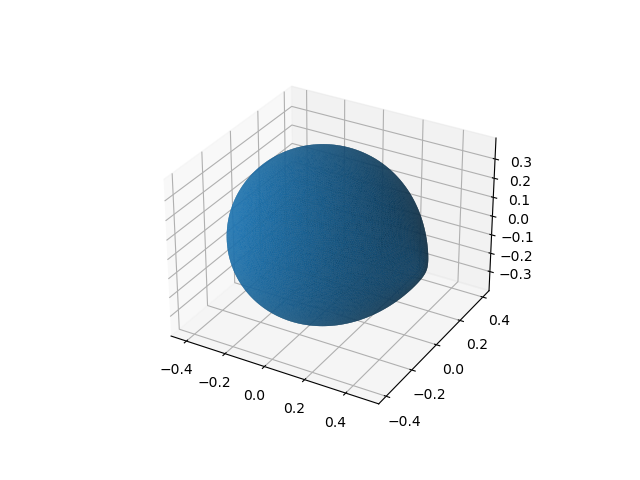

In [16]:
%matplotlib widget
colors = cm.jet(plt.Normalize(gn.min(), gn.max())(gn))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(V[:,0], V[:,1], V[:,2], triangles = T, facecolors = colors) # facecolors is ignored ??

### Contact stars

In [17]:
%%time

q = 0.5
F = 0.5
d = 1
Omega0 = 2.65
delta = 0.01
choice = 2
max_triangles = 10000000 # 10^7

misalignment = np.array([0, 0, 1.])

res = libphoebe.roche_misaligned_marching_mesh(q, F, d, misalignment, Omega0, delta, choice, max_triangles, 
                                               vertices=True, triangles=True, 
                                               cnormgrads=True, area=True, volume=True, full = True)

CPU times: user 116 ms, sys: 4 ms, total: 120 ms
Wall time: 119 ms


In [18]:
V = res["vertices"]
T = res["triangles"]
gn = res["cnormgrads"]

print("area= {:.16e}\nvolume={:.16e}".format(res["area"], res["volume"]))
print("marching_mesh: V.size= {}, T.size={}".format(V.shape[0], T.shape[0]))

area= 3.7266055859124410e+00
volume=5.2579276701759603e-01
marching_mesh: V.size= 48525, T.size=97046


In [19]:
import matplotlib.pyplot as plt
from matplotlib import cm

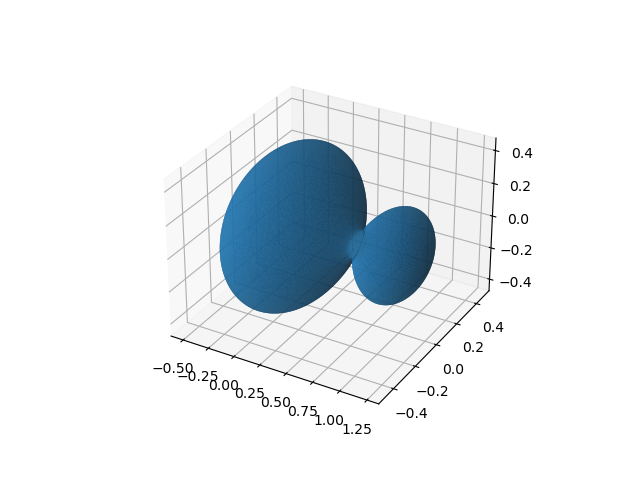

In [20]:
%matplotlib widget
colors = cm.jet(plt.Normalize(gn.min(), gn.max())(gn))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(V[:,0], V[:,1], V[:,2], triangles = T, facecolors = colors) # facecolors is ignored ??

## Source code and adding own code

The source of libphoebe can be found in PHOEBE2-GIT/phoebe/lib

In [21]:
!ls ~/PHOEBE2-GIT/phoebe/lib

bodies.h		 horizon.h	     refinement.h
clipper.h		 interpolation.h     reflection.h
contact.h		 ld_models.h	     rot_star.h
eclipsing.h		 libphoebe.cpp	     sincos.h
gen_roche.h		 libphoebe.so	     triang_marching.h
gen_roche_lagrange_L1.h  Makefile	     triang_mesh.h
gen_roche_lagrange_L2.h  misaligned_roche.h  utils.h
gen_roche_lagrange_L3.h  povray.h	     wd_atm.h
hash.h			 redistribution.h


The main library file is **libphoebe.cpp** and supporting source code is in headers *.h files. The library in build at the same time as PHOEBE in build or installed.

To add your own routine to **libphoebe** it is useful to check the manual

  https://docs.python.org/3/c-api/index.html

The you add routine to **liphoebe.cpp** in the form

```cpp
static PyObject *your_test_function(PyObject *self, PyObject *args, PyObject *keywds) {
  
  auto fname = "your_test_function"_s;

  //
  // Reading arguments
  //

  char *kwlist[] = {
    (char*)"a",
    (char*)"b",
    (char*)"c",
    NULL
  };
    
  double a, b, c;


  if (!PyArg_ParseTupleAndKeywords(
      args, keywds,  "ddd", kwlist,
      &a, &b, &c)){
    raise_exception(fname + "::Problem reading arguments");
    return NULL;
  }

  // do someting with a b, c   
  double v[3] = {a,b,c};
    
    
  // store results back to python list object
  // Ref: 
  //   * https://docs.python.org/3/c-api/list.html
  //   * https://docs.python.org/3/c-api/float.html  
  PyObject *results = PyList_New(3);
    
  for (int i = 0; i < 3; ++i)    
      PyList_SetItem(results, i, PyFloat_FromDouble(v[i]));
    
  return results;
}
```
and then section "static PyMethodDef Methods[] = {" of **liphoebe.cpp** add description to the routine
```cpp

  {"your_test_function",
    (PyCFunction)your_test_function,
    METH_VARARGS|METH_KEYWORDS,
    "Function for testing ideas."},
```
just before the terminator record
```cpp
  {NULL,  NULL, 0, NULL} // terminator record
```

Not it is time to test whether added routine is Ok. Let us check wether the libphoebe compiles:
```bash
cd PHOEBE2-GIT/phoebe/lib
make
```
It this succeeds than you can test rutines itself:
```bash
PHOEBE2-GIT/phoebe/lib$ python3
Python 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import libphoebe
>>> libphoebe.your_test_function(1,2,3)
[1.0, 2.0, 3.0]
>>> 
```

If this goes well we can reinstall phoebe with new addition to libphoebe:
```bash
cd PHOEBE2-DIR
python3 setup.py install --user
```